In [ ]:

# !pip install transformers==4.29.2


In [22]:
import clip
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import os
import re
import skimage.io as io
import textwrap

import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from IPython.display import Image 
from PIL import Image
from pkg_resources import packaging
from nltk import edit_distance
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from sklearn.model_selection import train_test_split
from torch import nn
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm, trange
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from typing import Tuple, List, Union, Optional


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'conceptual_weights.pt')

model_path = "./pretrained_models/conceptual_weights.pt"


In [4]:
class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('./pretrained_models/', local_files_only = True)
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [5]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [7]:
is_gpu = True

In [8]:
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
print("Successfully loaded CLIP.")

Successfully loaded CLIP.


In [9]:
tokenizer = GPT2Tokenizer.from_pretrained(
    "./pretrained_models/",
    local_files_only = True
)
print("Successfully loaded GPT2 Tokenizer.")

Successfully loaded GPT2 Tokenizer.


In [10]:
model_path = "./pretrained_models/coco_weights.pt"

prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


In [13]:
# Load Flickr8k dataset

annotations_path = "./data/"
annotations = pd.read_csv(annotations_path + "captions.txt")
print(annotations[:5])

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [14]:
sp = annotations['image'].drop_duplicates()
# sp = sp.sample(100, replace = False)

In [16]:
new_captions = {}
start_marker = "<start_of_text>"
end_marker = "<end_of_text>"

use_beam_search = False

i = 0
for image_name in sp:
    i += 1
    if i % 100 == 0:
        print(f"#{i} image captioning done.")
    image_path = annotations_path + "Images/" + image_name
    im = Image.open(image_path).convert("RGB")
    im = preprocess(im).unsqueeze(0).to(device)
    with torch.no_grad():
        # if type(model) is ClipCaptionE2E:
        #     prefix_embed = model.forward_image(image)
        # else:
        prefix = clip_model.encode_image(im).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
    caption = generated_text_prefix
    new_captions[image_name] = [caption]

#20 image captioning done.
#40 image captioning done.
#60 image captioning done.
#80 image captioning done.
#100 image captioning done.
#120 image captioning done.
#140 image captioning done.
#160 image captioning done.
#180 image captioning done.
#200 image captioning done.
#220 image captioning done.
#240 image captioning done.
#260 image captioning done.
#280 image captioning done.
#300 image captioning done.
#320 image captioning done.
#340 image captioning done.
#360 image captioning done.
#380 image captioning done.
#400 image captioning done.
#420 image captioning done.
#440 image captioning done.
#460 image captioning done.
#480 image captioning done.
#500 image captioning done.
#520 image captioning done.
#540 image captioning done.
#560 image captioning done.
#580 image captioning done.
#600 image captioning done.
#620 image captioning done.
#640 image captioning done.
#660 image captioning done.
#680 image captioning done.
#700 image captioning done.
#720 image captioning do

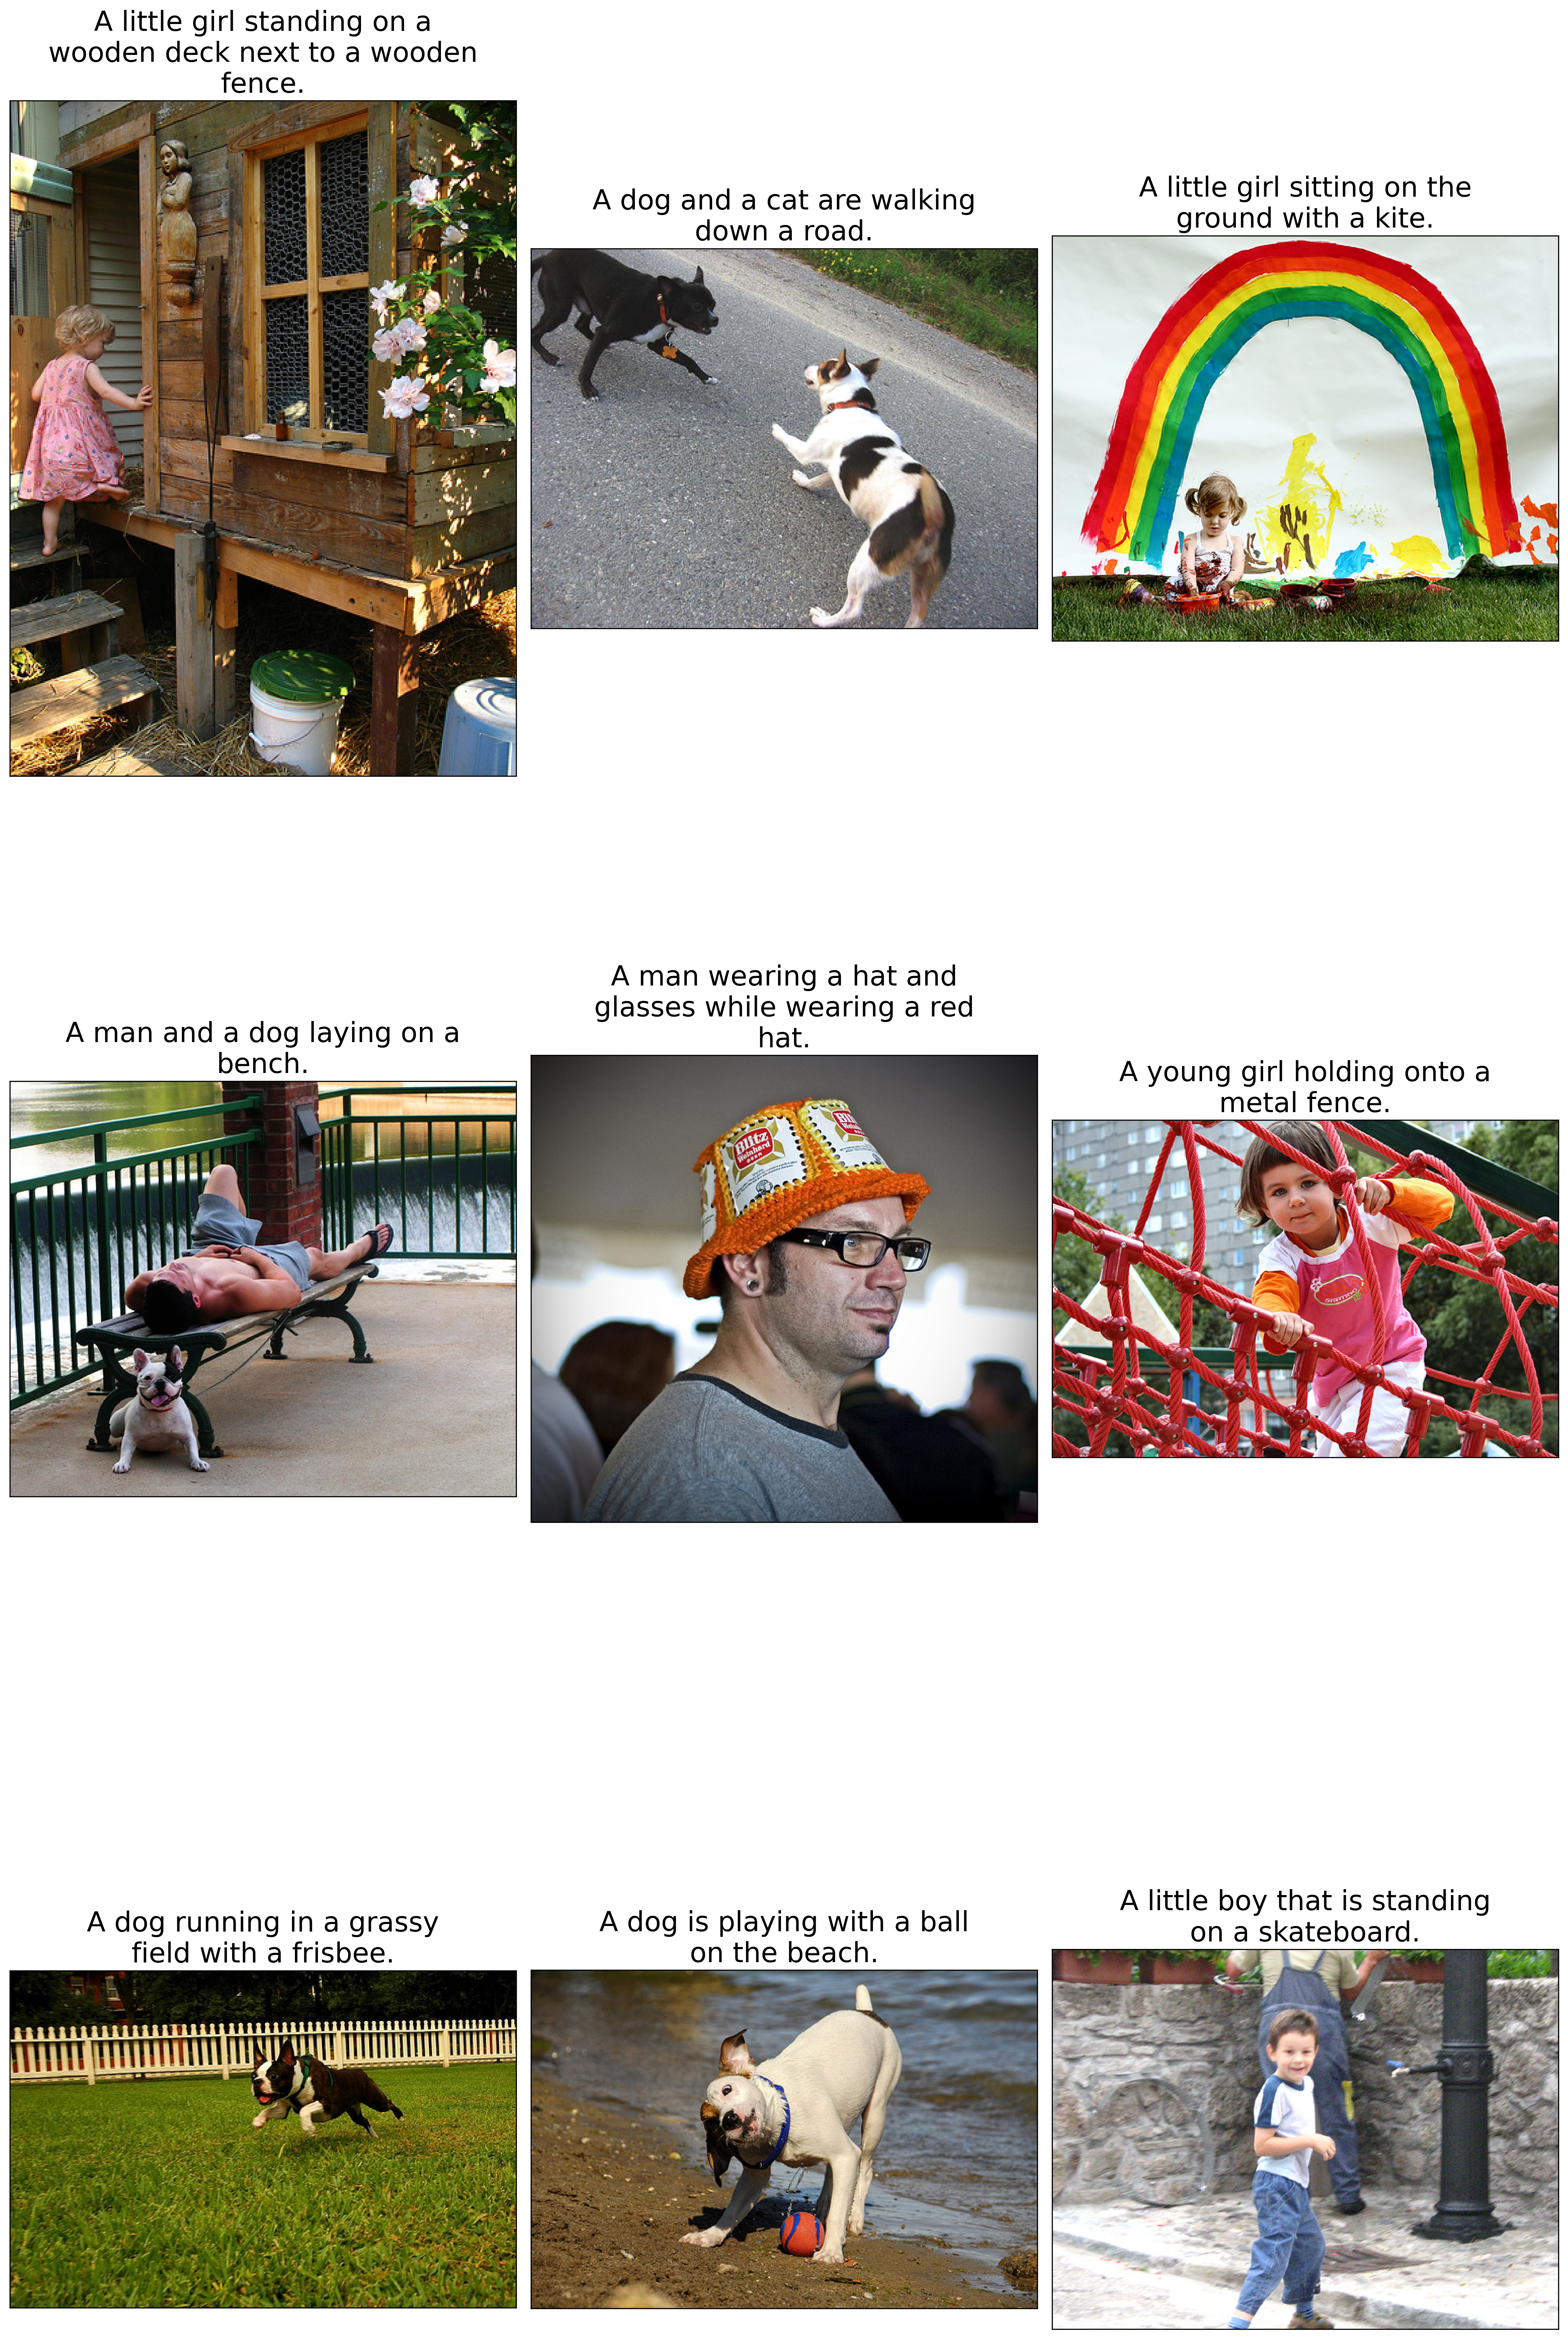

In [17]:
plt.figure(figsize = (16, 28), dpi = 300)
i = 0

for image_name, caption in list(new_captions.items())[:9]:
    caption = caption[0]
    image = Image.open(annotations_path + "Images/" + image_name).convert("RGB")
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    description_wrapped = "\n".join(textwrap.wrap(caption, width=30))
    plt.title(description_wrapped, size=20, y=1)
    plt.xticks([])
    plt.yticks([])
    i += 1

plt.tight_layout()

In [18]:
ps = PorterStemmer()

# Extract the stem of the words in a sentence, for example, "He was running." -> "he is run ." 
# Set recover = True to recover the splitted list back to a string.
def extract_stem(s, recover = True):
    words = word_tokenize(s)
    stemmed_words = [ps.stem(word) for word in words]
    if recover:
        return " ".join(stemmed_words)
    return stemmed_words

extract_stem("He is running.")

'he is run .'

In [19]:
bleu_scores_per_image = []
smooth = SmoothingFunction()
for image_name, caption in new_captions.items():
    reference_captions = annotations[annotations["image"] == image_name]["caption"]
    
    bleu = sentence_bleu([
        extract_stem(ref, False) for ref in reference_captions], 
        extract_stem(caption[0], False), 
        smoothing_function = smooth.method7
    )
    bleu_scores_per_image.append(bleu)

average_bleu_per_image = 100 * sum(bleu_scores_per_image) / len(bleu_scores_per_image)
print(f"Average BLEU Score per Image: {average_bleu_per_image : .2f}")


Average BLEU Score per Image:  31.03


In [20]:
d1 = copy.deepcopy(new_captions)
d2 = copy.deepcopy(annotations[annotations["image"].isin(sp)].groupby('image')['caption'].apply(list).to_dict())

assert d1.keys() == d2.keys()
for key in d1:
    d1[key] = [extract_stem(d1[key][0])]
    d2[key] = [extract_stem(si) for si in d2[key]]


In [21]:
# Compute CIDEr Score
cider_scorer = Cider()
cider_scores = cider_scorer.compute_score(d2, d1)

print(f"Average CIDEr Score per Image: {cider_scores[0]}")

Average CIDEr Score per Image: 0.6388354549801664
